# Sarcasm Detection using the Pre-Trained BERT model from Transformers 

In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
data = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
labels = data.is_sarcastic.values
sentences = data.headline.values
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


**Tokenizing all the sentences using pre-trained BERT model from Tranformers**

In [4]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case = True)

def encoder(sentences):
  ids = []
  for sentence in sentences:
    encoding = tokenizer.encode_plus(
    sentence,
    max_length=16,
    truncation = True,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=False)
    ids.append(encoding['input_ids'])
  return ids

#Train test split
train_sents,test_sents, train_labels, test_labels  = train_test_split(sentences,labels,test_size=0.20, random_state=3)
dev_sents,test_sents, dev_labels, test_labels  = train_test_split(test_sents,test_labels,test_size=0.50, random_state=3)

train_ids = encoder(train_sents)
dev_ids = encoder(dev_sents)
test_ids = encoder(test_sents) 

Converting arrays to tensors

In [5]:
train_ids = tf.convert_to_tensor(train_ids)
train_labels = tf.convert_to_tensor(train_labels)

dev_ids = tf.convert_to_tensor(dev_ids)
dev_labels = tf.convert_to_tensor(dev_labels)

test_ids = tf.convert_to_tensor(test_ids)
test_labels = tf.convert_to_tensor(test_labels)


Building Model from transformers using pre-trained bert-base-uncased (12-layer, 768-hidden, 12-heads, 110M parameters.)

In [6]:
bert_encoder = TFBertModel.from_pretrained('bert-base-uncased')
input_word_ids = tf.keras.Input(shape=(16,), dtype=tf.int32, name="input_word_ids")  
embedding = bert_encoder([input_word_ids])
dense = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(embedding[0])
#dense = tf.keras.layers.Dense(128, activation='relu')(dense)
dense = tf.keras.layers.Dense(256, activation='relu')(dense)
dense = tf.keras.layers.Dense(128, activation='tanh')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)

output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)    


model = tf.keras.Model(inputs=[input_word_ids], outputs=output)  


In [7]:
model.compile(tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 16)]              0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 16, 768), (None,  109482240 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               196864    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [8]:
history = model.fit(x = train_ids, y = train_labels, epochs = 15, verbose = 1, batch_size = 64, validation_data = (dev_ids, dev_labels))

Epoch 1/15
358/358 [==============================] - 62s 173ms/step - loss: 0.3313 - accuracy: 0.8569 - val_loss: 0.2938 - val_accuracy: 0.8826
Epoch 2/15
358/358 [==============================] - 58s 163ms/step - loss: 0.1950 - accuracy: 0.9246 - val_loss: 0.2358 - val_accuracy: 0.9067
Epoch 3/15
358/358 [==============================] - 58s 163ms/step - loss: 0.1244 - accuracy: 0.9523 - val_loss: 0.2472 - val_accuracy: 0.9102
Epoch 4/15
358/358 [==============================] - 58s 163ms/step - loss: 0.0773 - accuracy: 0.9716 - val_loss: 0.2646 - val_accuracy: 0.9151
Epoch 5/15
358/358 [==============================] - 59s 164ms/step - loss: 0.0500 - accuracy: 0.9837 - val_loss: 0.3116 - val_accuracy: 0.9109
Epoch 6/15
358/358 [==============================] - 58s 163ms/step - loss: 0.0298 - accuracy: 0.9901 - val_loss: 0.3614 - val_accuracy: 0.9154
Epoch 7/15
358/358 [==============================] - 58s 163ms/step - loss: 0.0228 - accuracy: 0.9927 - val_loss: 0.3552 - val_ac

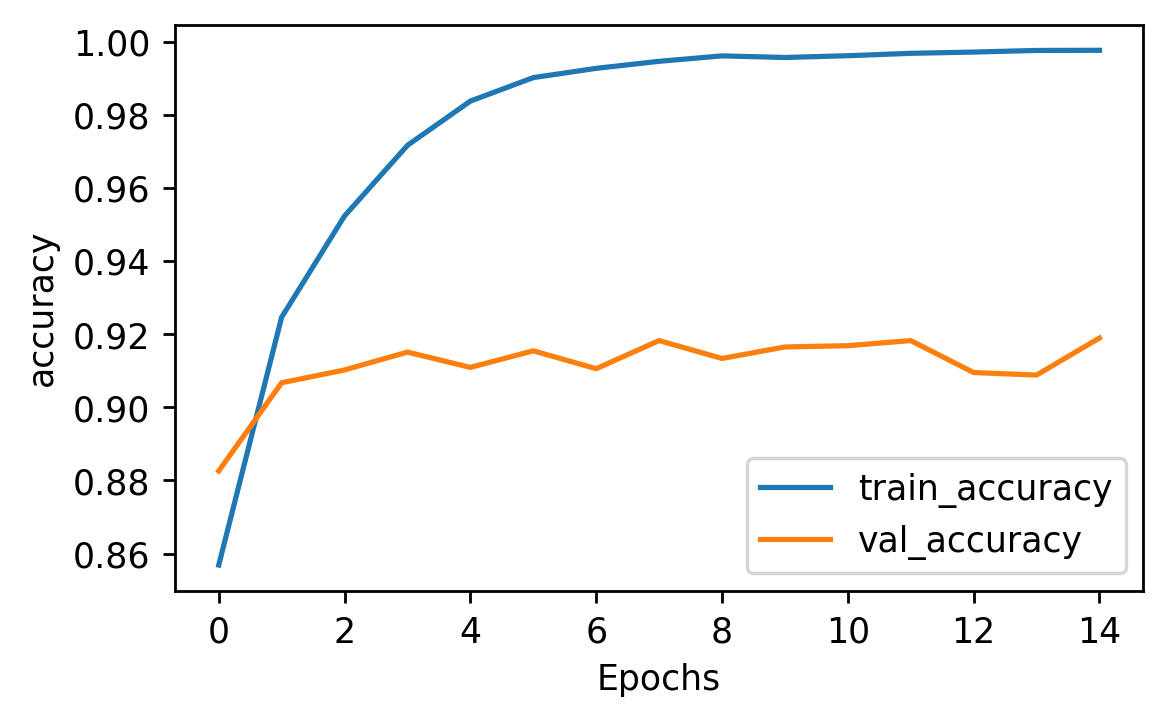

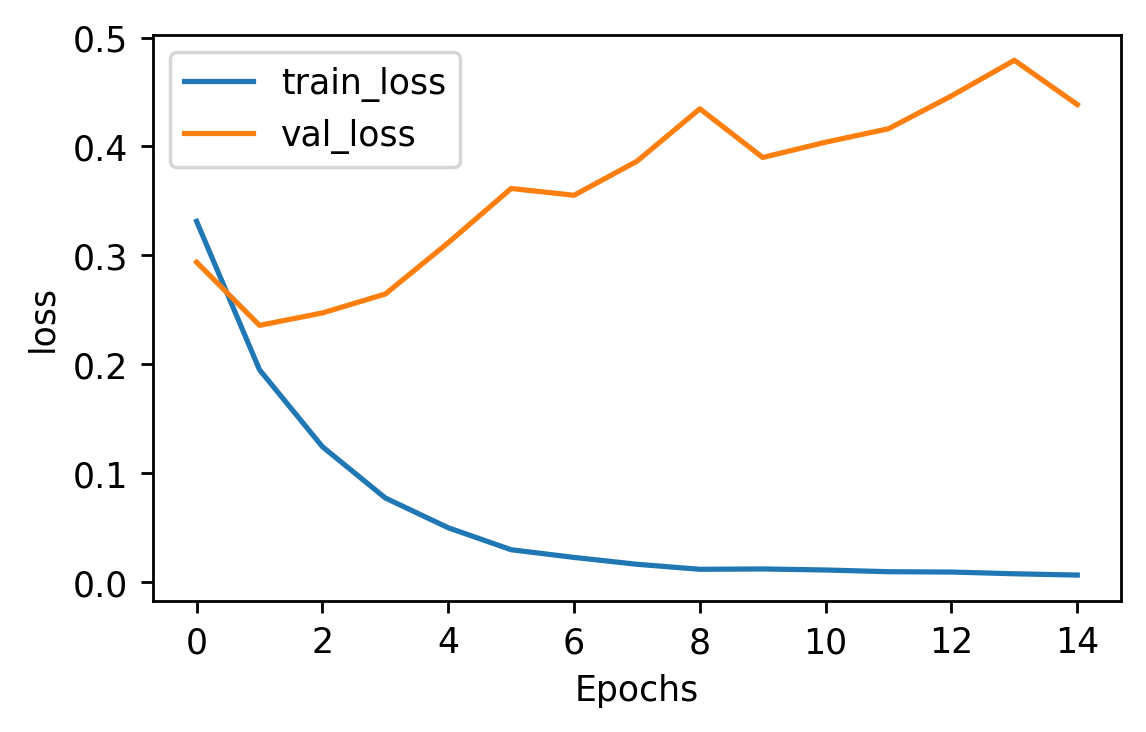

In [9]:
#from matplotlib.pyplot import figure


def plot_graphs(history, string):
  plt.figure(figsize=(5, 3), dpi=250)
    
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend(['train_'+string, 'val_'+string])
  
  plt.savefig(string+'.png')
  plt.show()
  

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')


In [10]:
pred_=model.predict(test_ids)

from sklearn.metrics import classification_report
pred_thrs=[]
for i in pred_:
    if i<0.5:
        pred_thrs.append(0)
    else:
        pred_thrs.append(1)
print(classification_report(test_labels, pred_thrs))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1464
           1       0.95      0.90      0.92      1398

    accuracy                           0.93      2862
   macro avg       0.93      0.92      0.93      2862
weighted avg       0.93      0.93      0.93      2862



In [11]:
pred_

array([[9.9994862e-01],
       [9.2183480e-05],
       [5.9860518e-05],
       ...,
       [9.9992704e-01],
       [9.9816185e-01],
       [5.7944602e-05]], dtype=float32)

In [12]:
with open("prediction.txt", "w") as output:
    output.write(str(pred_thrs))

In [13]:
test_sents1=['obama says voting barriers are directly linked to jim crow and slavery']
test_sents1_ids=encoder(test_sents1)
pred_=model.predict(test_sents1_ids)
pred_

array([[9.218348e-05]], dtype=float32)

In [14]:
import pickle

#pickle.dump(model, open('bert_sarcasm_classifier.pkl', 'wb'))
model.save_weights('bert_sarcasm_classifier')

In [15]:
with open("test_sents.txt", "w") as output:
    output.write(str(test_sents.tolist()))